# Exploratory Data Analysis for xG Tutor

This notebook explores the StatsBomb-derived SQLite dataset used by **xG Tutor**.
We will audit data quality, engineer key shot geometry features (distance and
angle), and look for early relationships between goal outcomes, StatsBomb xG,
and other shot attributes.

## Imports & Notebook Setup

We start by loading the Python packages needed for data access, numerical
analysis, and visualization.

In [1]:
import json
import math
import sqlite3
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_columns = 60
pd.options.display.float_format = "{:.3f}".format
sns.set_context("notebook")

## Load the StatsBomb-Derived Dataset

Set the path to the SQLite database populated by the ETL pipeline. If you have
not run the loader yet, execute the following command from the project root to
create `data/xg_tutor.db` first:

```bash
poetry run python -m xgoal_tutor.etl /path/to/events.json data/xg_tutor.db
```

Update `DB_PATH` below if you store the database elsewhere.

In [7]:
DB_PATH = Path("../data/xgoal-db.sqlite")
if not DB_PATH.exists():
    raise FileNotFoundError(
        "SQLite database not found. Run the ETL loader before executing the notebook."
    )

with sqlite3.connect(DB_PATH) as conn:
    shots = pd.read_sql("SELECT * FROM shots", conn)
    events = pd.read_sql("SELECT * FROM events", conn)
    freeze_frames = pd.read_sql("SELECT * FROM freeze_frames", conn)

shots.head()

,shot_id,match_id,team_id,opponent_team_id,player_id,possession,possession_team_id,period,minute,second,timestamp,play_pattern,start_x,start_y,end_x,end_y,end_z,outcome,body_part,technique,shot_type,assist_type,key_pass_id,statsbomb_xg,first_time,one_on_one,open_goal,follows_dribble,deflected,aerial_won,rebound,under_pressure,is_set_piece,is_corner,is_free_kick,is_penalty,is_throw_in,is_kick_off,is_own_goal,freeze_frame_available,freeze_frame_count
0,becd7956-ce44-479e-8fc9-16a2d1f1f349,9,217,206,5503,6,217,1,2,29.000,00:02:29.477,From Throw In,111.500,52.900,120.000,34.100,0.900,Off T,Right Foot,Half Volley,Open Play,None,96c89235-1a30-47d0-accd-81309e05f4c3,0.077,1.000,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,0,0,0,0,0,1,11
1,9107d374-2942-4876-a14f-1b9f86901c15,9,217,206,5211,12,217,1,5,39.000,00:05:39.641,Regular Play,113.900,26.400,120.000,35.500,1.000,Off T,Left Foot,Volley,Open Play,None,c88615ba-1774-4f57-a408-77436c5227df,0.052,1.000,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,0,0,0,0,0,1,17
2,ddd194ca-08fb-43d0-87c2-33647f975f9f,9,217,206,5503,23,217,1,15,29.000,00:15:29.059,From Keeper,93.700,34.700,117.500,38.000,0.700,Saved,Left Foot,Normal,Open Play,None,None,0.017,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,0,0,0,0,0,1,16
3,86596ddb-d824-4e5e-b18c-b4442e9ce7cf,9,206,217,6613,30,206,1,16,20.000,00:16:20.072,Regular Play,109.200,39.100,120.000,32.500,1.100,Off T,Head,Normal,Open Play,Cross,45370bb0-dc53-405b-bdf4-9a108fc5e9f9,0.123,NaN,NaN,NaN,NaN,NaN,1.000,None,1.000,0,0,0,0,0,0,0,1,11
4,3ed2b107-be17-42d5-9d1b-25006a0e55cb,9,217,206,5246,33,217,1,18,16.000,00:18:16.362,From Corner,107.800,24.700,120.000,44.400,3.800,Off T,Right Foot,Normal,Open Play,None,None,0.042,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,0,0,0,0,0,1,18


## Initial Data Audit

Inspect the basic structure and completeness of the `shots` table to surface
potential data quality issues.

In [8]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88023 entries, 0 to 88022
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   shot_id                 88023 non-null  object 
 1   match_id                88023 non-null  int64  
 2   team_id                 88023 non-null  int64  
 3   opponent_team_id        88023 non-null  int64  
 4   player_id               88023 non-null  int64  
 5   possession              88023 non-null  int64  
 6   possession_team_id      88023 non-null  int64  
 7   period                  88023 non-null  int64  
 8   minute                  88023 non-null  int64  
 9   second                  88023 non-null  float64
 10  timestamp               88023 non-null  object 
 11  play_pattern            88023 non-null  object 
 12  start_x                 88023 non-null  float64
 13  start_y                 88023 non-null  float64
 14  end_x                   88023 non-null

In [9]:
missing_summary = (
    shots.isna()
    .mean()
    .rename("missing_fraction")
    .to_frame()
    .assign(missing_count=shots.isna().sum())
    .sort_values("missing_fraction", ascending=False)
)
missing_summary.head(20)

,missing_fraction,missing_count
rebound,1.000,88023
follows_dribble,0.999,87952
open_goal,0.989,87078
deflected,0.987,86871
one_on_one,0.947,83362
aerial_won,0.917,80717
under_pressure,0.763,67132
first_time,0.697,61373
assist_type,0.685,60326
end_z,0.301,26500


In [11]:
shots.describe(include="all")

,shot_id,match_id,team_id,opponent_team_id,player_id,possession,possession_team_id,period,minute,second,timestamp,play_pattern,start_x,start_y,end_x,end_y,end_z,outcome,body_part,technique,shot_type,assist_type,key_pass_id,statsbomb_xg,first_time,one_on_one,open_goal,follows_dribble,deflected,aerial_won,rebound,under_pressure,is_set_piece,is_corner,is_free_kick,is_penalty,is_throw_in,is_kick_off,is_own_goal,freeze_frame_available,freeze_frame_count
count,88023,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023,88023,88023.000,88023.000,88023.000,88023.000,61523.000,88023,88023,88023,88023,27697,62012,88023.000,26650.000,4661.000,945.000,71.000,1152.000,7306.000,0,20891.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000,88023.000
unique,88023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86708,9,NaN,NaN,NaN,NaN,NaN,8,4,7,5,10,62012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,becd7956-ce44-479e-8fc9-16a2d1f1f349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:05:13.483,Regular Play,NaN,NaN,NaN,NaN,NaN,Off T,Right Foot,Normal,Open Play,Cross,96c89235-1a30-47d0-accd-81309e05f4c3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,29180,NaN,NaN,NaN,NaN,NaN,28466,46184,68665,82402,12627,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,415441735134574144.000,751.795,827.864,24365.095,103.564,752.559,1.566,49.136,29.449,NaN,NaN,103.590,39.764,115.574,40.002,1.904,NaN,NaN,NaN,NaN,NaN,NaN,0.107,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.064,0.000,0.048,0.015,0.000,0.000,0.000,0.986,12.760
std,NaN,1557177975315089408.000,1635.911,1866.804,59957.070,56.689,1641.395,0.563,27.270,17.352,NaN,NaN,8.795,9.886,6.698,7.038,1.887,NaN,NaN,NaN,NaN,NaN,NaN,0.150,0.000,0.000,0.000,0.000,0.000,0.000,NaN,0.000,0.245,0.018,0.214,0.123,0.000,0.003,0.000,0.115,3.910
min,NaN,0.000,1.000,1.000,2935.000,2.000,1.000,1.000,0.000,0.000,NaN,NaN,30.200,0.300,66.500,0.100,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,NaN,9.000,171.000,172.000,5211.000,56.000,171.000,1.000,26.000,14.000,NaN,NaN,97.300,32.500,113.600,36.200,0.400,NaN,NaN,NaN,NaN,NaN,NaN,0.028,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,10.000
50%,NaN,80.000,220.000,221.000,7456.000,104.000,219.000,2.000,49.000,29.000,NaN,NaN,105.000,40.000,119.000,40.000,1.200,NaN,NaN,NaN,NaN,NaN,NaN,0.055,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,13.000
75%,NaN,853.000,798.000,860.000,19298.000,149.000,798.000,2.000,72.000,44.000,NaN,NaN,110.600,47.000,120.000,43.800,2.800,NaN,NaN,NaN,NaN,NaN,NaN,0.110,1.000,1.000,1.000,1.000,1.000,1.000,NaN,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,16.000


### Logical Consistency Checks

A few quick validation queries help reveal duplicated identifiers and confirm
basic assumptions about coordinates and categorical values.

In [12]:
consistency_checks = {
    "duplicate_shot_ids": shots["shot_id"].duplicated().sum(),
    "unique_outcomes": shots["outcome"].dropna().unique(),
    "start_x_range": shots["start_x"].agg(["min", "max"]),
    "start_y_range": shots["start_y"].agg(["min", "max"]),
}
consistency_checks

{'duplicate_shot_ids': np.int64(0),
 'unique_outcomes': array(['Off T', 'Saved', 'Wayward', 'Post', 'Blocked', 'Goal',
        'Saved to Post', 'Saved Off Target'], dtype=object),
 'start_x_range': min    30.200
 max   120.500
 Name: start_x, dtype: float64,
 'start_y_range': min    0.300
 max   80.000
 Name: start_y, dtype: float64}

## Geometry Feature Engineering

StatsBomb encodes shot locations on a 120×80 pitch. We map those coordinates to
real-world dimensions (105×68 meters) and compute two key geometry features:

- **Distance to the goal center** in meters
- **Goal opening angle** in both radians and degrees

In [13]:
SB_PITCH_LENGTH = 120.0
SB_PITCH_WIDTH = 80.0
REAL_PITCH_LENGTH = 105.0
REAL_PITCH_WIDTH = 68.0
GOAL_WIDTH = 7.32
GOAL_X = REAL_PITCH_LENGTH
GOAL_Y = REAL_PITCH_WIDTH / 2
UPPER_POST_Y = GOAL_Y - GOAL_WIDTH / 2
LOWER_POST_Y = GOAL_Y + GOAL_WIDTH / 2


def statsbomb_to_metric(x: pd.Series, y: pd.Series) -> tuple[pd.Series, pd.Series]:
    """Convert StatsBomb shot coordinates to metric units."""

    scale_x = REAL_PITCH_LENGTH / SB_PITCH_LENGTH
    scale_y = REAL_PITCH_WIDTH / SB_PITCH_WIDTH
    return x * scale_x, y * scale_y


def goal_distance(x_m: pd.Series, y_m: pd.Series) -> pd.Series:
    """Compute Euclidean distance to the goal center in meters."""

    return np.hypot(GOAL_X - x_m, GOAL_Y - y_m)


def goal_opening_angle(x_m: pd.Series, y_m: pd.Series) -> pd.Series:
    """Compute the goal opening angle (radians) from the shot location."""

    shot_points = np.column_stack([x_m, y_m])
    upper_post = np.array([GOAL_X, UPPER_POST_Y])
    lower_post = np.array([GOAL_X, LOWER_POST_Y])

    vec_upper = upper_post - shot_points
    vec_lower = lower_post - shot_points

    dot = np.einsum("ij,ij->i", vec_upper, vec_lower)
    norms = np.linalg.norm(vec_upper, axis=1) * np.linalg.norm(vec_lower, axis=1)

    cos_theta = np.clip(dot / norms, -1.0, 1.0)
    return np.arccos(cos_theta)


shots = shots.copy()
shots["start_x_m"], shots["start_y_m"] = statsbomb_to_metric(shots["start_x"], shots["start_y"])
shots["distance_to_goal_m"] = goal_distance(shots["start_x_m"], shots["start_y_m"])
shots["goal_angle_rad"] = goal_opening_angle(shots["start_x_m"], shots["start_y_m"])
shots["goal_angle_deg"] = np.degrees(shots["goal_angle_rad"])

shots[[
    "shot_id",
    "start_x",
    "start_y",
    "start_x_m",
    "start_y_m",
    "distance_to_goal_m",
    "goal_angle_rad",
    "goal_angle_deg",
]].head()

,shot_id,start_x,start_y,start_x_m,start_y_m,distance_to_goal_m,goal_angle_rad,goal_angle_deg
0,becd7956-ce44-479e-8fc9-16a2d1f1f349,111.500,52.900,97.562,44.965,13.249,0.324,18.559
1,9107d374-2942-4876-a14f-1b9f86901c15,113.900,26.400,99.663,22.440,12.733,0.257,14.719
2,ddd194ca-08fb-43d0-87c2-33647f975f9f,93.700,34.700,81.987,29.495,23.449,0.304,17.432
3,86596ddb-d824-4e5e-b18c-b4442e9ce7cf,109.200,39.100,95.550,33.235,9.481,0.735,42.124
4,3ed2b107-be17-42d5-9d1b-25006a0e55cb,107.800,24.700,94.325,20.995,16.825,0.282,16.159


### Geometry Feature Distributions

Plot the distributions of the engineered geometry features to understand their
ranges and detect potential outliers.

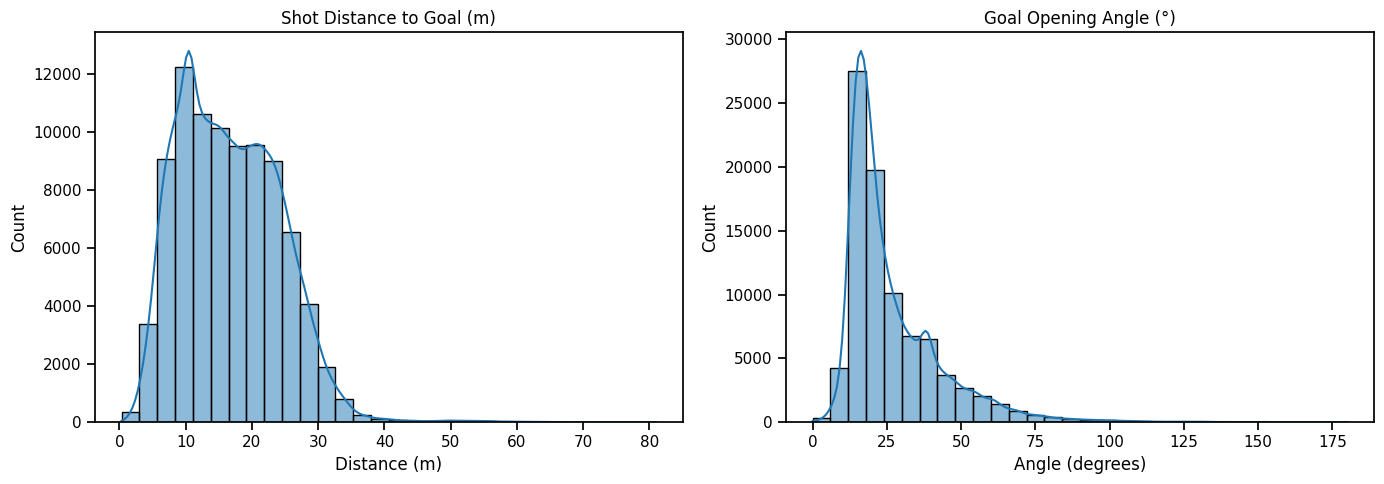

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(shots["distance_to_goal_m"], kde=True, bins=30, ax=axes[0])
axes[0].set_title("Shot Distance to Goal (m)")
axes[0].set_xlabel("Distance (m)")

sns.histplot(shots["goal_angle_deg"], kde=True, bins=30, ax=axes[1])
axes[1].set_title("Goal Opening Angle (°)")
axes[1].set_xlabel("Angle (degrees)")

plt.tight_layout()
plt.show()

## Relationship Between Outcomes and Features

Add helper columns for goal outcomes and inspect how distance, angle, and
StatsBomb xG differ between scoring and non-scoring shots.

In [15]:
shots["is_goal"] = shots["outcome"].eq("Goal")

summary_by_outcome = shots.groupby("is_goal")[
    ["distance_to_goal_m", "goal_angle_deg", "statsbomb_xg"]
].agg(["mean", "median", "std", "count"])
summary_by_outcome

distance_to_goal_m                     goal_angle_deg                \
                      mean median   std  count           mean median    std   
is_goal                                                                       
False               17.342 16.927 7.561  78233         25.121 19.985 14.383   
True                11.278 10.413 5.829   9790         40.865 37.173 23.675   

               statsbomb_xg                      
         count         mean median   std  count  
is_goal                                          
False    78233        0.081  0.049 0.103  78233  
True      9790        0.309  0.210 0.267   9790

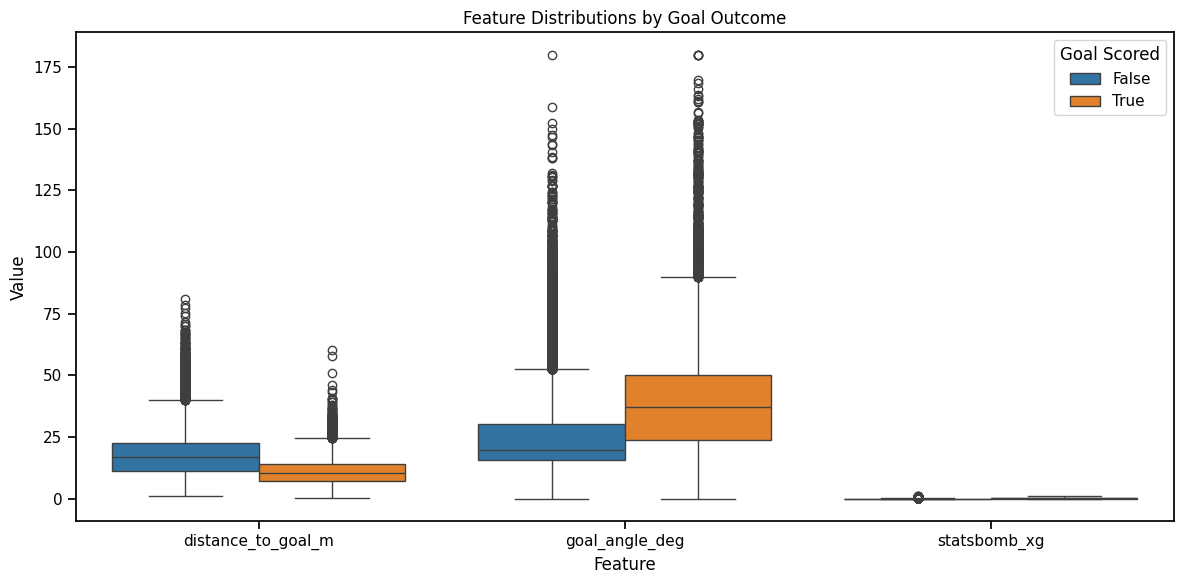

In [16]:
melted = shots.melt(
    id_vars=["is_goal"],
    value_vars=["distance_to_goal_m", "goal_angle_deg", "statsbomb_xg"],
    var_name="feature",
    value_name="value",
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x="feature", y="value", hue="is_goal")
plt.title("Feature Distributions by Goal Outcome")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.legend(title="Goal Scored")
plt.tight_layout()
plt.show()

### Correlation Matrix

Compute a correlation matrix between StatsBomb xG, the engineered geometry
features, and a selection of contextual flags to identify promising modelling
signals.

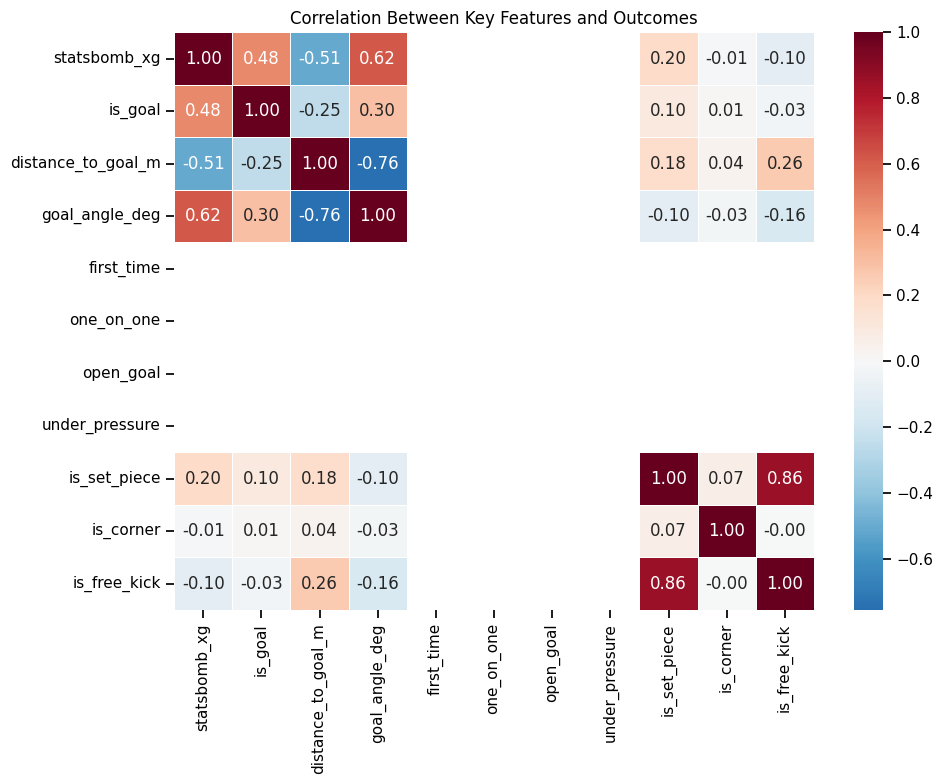

In [17]:
corr_features = [
    "statsbomb_xg",
    "is_goal",
    "distance_to_goal_m",
    "goal_angle_deg",
    "first_time",
    "one_on_one",
    "open_goal",
    "under_pressure",
    "is_set_piece",
    "is_corner",
    "is_free_kick",
]

corr_matrix = shots[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
)
plt.title("Correlation Between Key Features and Outcomes")
plt.tight_layout()
plt.show()

## Next Steps

- Investigate additional contextual features (defensive pressure, body part,
  play pattern) for predictive power.
- Blend geometry metrics with freeze-frame derived defender proximity features.
- Calibrate an initial xG model using the engineered feature set.